In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset
import copy
import os
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
folder = '/data/fyy/new_prediction/dataset/co-driving_dataset/data/data_shared_fyy'
csv_files = [f for f in os.listdir(folder) if f.endswith('.csv')]
trajs = []
for file in csv_files:
    file_path = os.path.join(folder, file)
    df = pd.read_csv(file_path)
    x, y, phi, v, lane_id = df['x'], df['y'], df['phi'], df['v'], df['lane_id']
    trajs.append(np.stack([x, y, phi, v, lane_id], axis=1))

folder = '/data/fyy/new_prediction/dataset/co-driving_dataset/data/data_shared_czj'
csv_files = [f for f in os.listdir(folder) if f.endswith('.csv')]
for file in csv_files:
    file_path = os.path.join(folder, file)
    df = pd.read_csv(file_path)
    x, y, phi, v, lane_id = df['x'], df['y'], df['phi'], df['v'], df['lane_id']
    trajs.append(np.stack([x, y, phi, v, lane_id], axis=1))
    
folder = '/data/fyy/new_prediction/dataset/co-driving_dataset/data/data_human_zmx'
csv_files = [f for f in os.listdir(folder) if f.endswith('.csv')]
for file in csv_files:
    file_path = os.path.join(folder, file)
    df = pd.read_csv(file_path)
    x, y, phi, v, lane_id = df['x'], df['y'], df['phi'], df['v'], df['lane_id']
    trajs.append(np.stack([x, y, phi, v, lane_id], axis=1))

In [4]:
df


,time,x,y,phi,v,lane_id
0,0.0,0.533175,-5.203335,-0.020372,8.963306,2
1,0.1,1.168490,-5.216568,-0.021241,8.934561,2
2,0.2,1.932745,-5.232551,-0.021697,8.899588,2
3,0.3,2.797032,-5.250622,-0.021796,8.859749,2
4,0.4,3.732445,-5.270115,-0.021597,8.816405,2
...,...,...,...,...,...,...
363,36.3,391.840032,-5.526770,-0.004217,14.187514,2
364,36.4,393.181960,-5.531951,-0.003401,14.157070,2
365,36.5,394.519083,-5.536000,-0.002586,14.126638,2
366,36.6,395.849359,-5.538890,-0.001771,14.096263,2


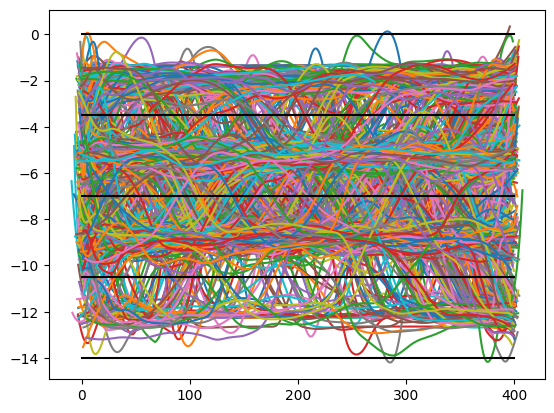

In [5]:
data_50 = []
for i in range(len(trajs)):
    num = len(trajs[i])//40
    for j in range(num):
        data_50.append(trajs[i][j*40:(j+1)*40])
    plt.plot(trajs[i][:, 0], trajs[i][:, 1])   
lane_0 = [[0, 0], [400, 0]] 
lane_1 = [[0, -3.5], [400, -3.5]]
lane_2 = [[0, -7], [400, -7]]
lane_3 = [[0, -10.5], [400, -10.5]]
lane_4 = [[0, -14], [400, -14]]
for lane in [lane_0, lane_1, lane_2, lane_3, lane_4]:
    plt.plot([lane[0][0], lane[1][0]], [lane[0][1], lane[1][1]], color='black')
# plt.axis('equal')

In [6]:
print("人机共驾数据总数", len(data_50))

人机共驾数据总数 10352


In [7]:
def is_monotonic(numbers):
    increasing = decreasing = True
    for i in range(1, len(numbers)):
        if numbers[i] > numbers[i - 1]:
            decreasing = False
        elif numbers[i] < numbers[i - 1]:
            increasing = False

    return increasing or decreasing

In [8]:
data_traj_and_label = []
s, l, r = 0, 0, 0
s_data, l_data, r_data, all_data = [], [], [], {}
idx = 0
for i in range(len(data_50)):
    traj = data_50[i]
    if not is_monotonic(traj[:, -1]):
        continue
    lane_start = traj[25][-1]
    lane_end = traj[-1][-1]
    if lane_start != lane_end and lane_start > lane_end:   # left
        data_traj_and_label.append([traj[:25], [0, 1, 0], idx])   
        l += 1
        l_data.append(traj)
    if lane_start != lane_end and lane_start < lane_end:   # right
        data_traj_and_label.append([traj[:25], [0, 0, 1], idx])
        r += 1
        r_data.append(traj)
    if lane_start == lane_end and s < 300:                             # straight
        data_traj_and_label.append([traj[:25], [1, 0, 0], idx])
        s += 1
        s_data.append(traj)
        
    all_data[idx] = traj
    idx += 1
    
# plt.plot(traj[:, 0], traj[:, 1])
# plt.plot(traj[19][0], traj[19][1], 'o')
# plt.plot(traj[-1][0], traj[-1][1], 'o')
# print(traj[0][-1], traj[-1][-1])
# for lane in [lane_0, lane_1, lane_2, lane_3, lane_4]:
#     plt.plot([lane[0][0], lane[1][0]], [lane[0][1], lane[1][1]], color='black')

In [9]:
print("左转数据总数", l)
print("右转数据总数", r)
print("直行数据总数", s)
print("总数", l+r+s)

左转数据总数 295
右转数据总数 321
直行数据总数 300
总数 916


In [10]:
import pickle
# 存储为 Pickle 文件
with open('data_traj_and_label.pkl', 'wb') as file:
    pickle.dump(data_traj_and_label, file)
    
with open('all_data.pkl', 'wb') as file:
    pickle.dump(all_data, file)

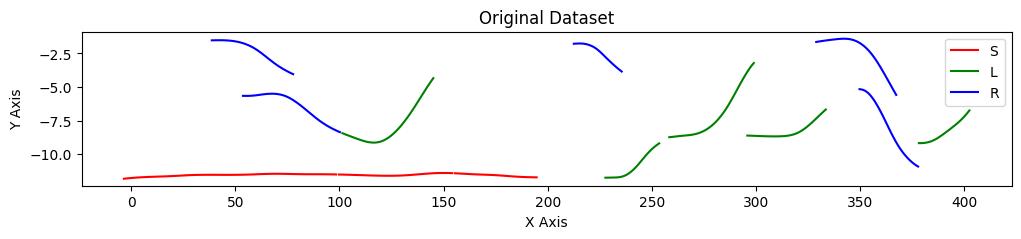

In [19]:
# 绘制 s_data 并设置标签为 'S'
plt.figure(figsize=(12, 2)) 
for i in range(5):
    traj = np.array(s_data[i])
    plt.plot(traj[:, 0], traj[:, 1], 'r', label='S' if i == 0 else "")


# 绘制 l_data 并设置标签为 'L'
for i in range(5):
    traj = np.array(l_data[i])
    plt.plot(traj[:, 0], traj[:, 1], 'g', label='L' if i == 0 else "")

# 绘制 r_data 并设置标签为 'R'
for i in range(5):
    traj = np.array(r_data[i])
    plt.plot(traj[:, 0], traj[:, 1], 'b', label='R' if i == 0 else "")

# plt.axis('equal')
plt.legend()

# 设置标题和坐标轴标签
plt.title("Original Dataset")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")

plt.savefig('data.png')

In [12]:
traj.shape

(40, 5)

MovieWriter imagemagick unavailable; using Pillow instead.


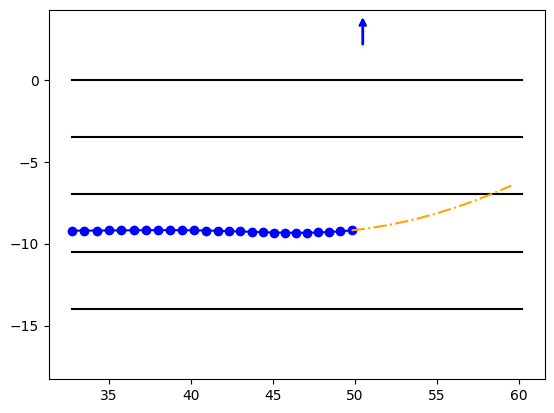

In [13]:
from matplotlib.animation import FuncAnimation

# 读取一条轨迹
idx = 20
traj = l_data[idx][:, :2]
start = traj[0][0]
end = traj[-1][0]

# 绘制道路信息
fig, ax = plt.subplots()
lane_0 = [[start, 0], [end, 0]]
lane_1 = [[start, -3.5], [end, -3.5]]
lane_2 = [[start, -7], [end, -7]]
lane_3 = [[start, -10.5], [end, -10.5]]
lane_4 = [[start, -14], [end, -14]]
for lane in [lane_0, lane_1, lane_2, lane_3, lane_4]:
    plt.plot([lane[0][0], lane[1][0]], [lane[0][1], lane[1][1]], color='black')
plt.axis('equal')

# 绘制动态轨迹，前25帧是蓝色，第25帧使用‘o’标注，后15帧是橙色
xdata, ydata = [], []
ln, = ax.plot([], [], '-o', animated=False)
ln.set_color('blue')
ln2, = ax.plot([], [], '-.', animated=False)
ln2.set_color('orange')
arrow_start = [traj[25][0], 2]
# arrow_end = [traj[25][0] + 5, 2]  # s
arrow_end = [traj[25][0], 4]  # l
# arrow_end = [traj[25][0], -2]  # r

arrowprops = dict(arrowstyle='->', linewidth=2, color='blue')
arrow_line = ax.annotate('', xy=arrow_end, xytext=arrow_start, arrowprops=arrowprops)
arrow_line.set_visible(False)

def init():
    return ln, ln2, arrow_line

def update(frame):
    xdata.append(traj[frame, 0])
    ydata.append(traj[frame, 1])

    if frame < 25:
        ln.set_data(xdata, ydata)
    elif frame == 25:
        # ln.set_data(xdata, ydata)
        ln.set_marker('o')
        arrow_line.set_visible(True)
    else:
        ln2.set_data(xdata[24:frame], ydata[24:frame])

    return ln, ln2, arrow_line

ani = FuncAnimation(fig=fig, func=update, frames=range(40), init_func=init, blit=True)
ani.save('fig.gif', writer='imagemagick', fps=100)


MovieWriter imagemagick unavailable; using Pillow instead.


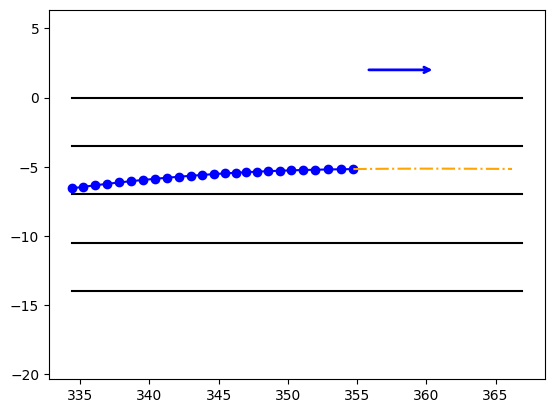

In [14]:
from matplotlib.animation import FuncAnimation

# 读取一条轨迹
idx = 20
traj = s_data[idx][:, :2]
start = traj[0][0]
end = traj[-1][0]

# 绘制道路信息
fig, ax = plt.subplots()
lane_0 = [[start, 0], [end, 0]]
lane_1 = [[start, -3.5], [end, -3.5]]
lane_2 = [[start, -7], [end, -7]]
lane_3 = [[start, -10.5], [end, -10.5]]
lane_4 = [[start, -14], [end, -14]]
for lane in [lane_0, lane_1, lane_2, lane_3, lane_4]:
    plt.plot([lane[0][0], lane[1][0]], [lane[0][1], lane[1][1]], color='black')
plt.axis('equal')


# 绘制动态轨迹，前25帧是蓝色，第25帧使用‘o’标注，后15帧是橙色
xdata, ydata = [], []
ln, = ax.plot([], [], '-o', animated=False)
ln.set_color('blue')
ln2, = ax.plot([], [], '-.', animated=False)
ln2.set_color('orange')

arrow_start = [traj[25][0], 2]
arrow_end = [traj[25][0] + 5, 2]
arrowprops = dict(arrowstyle='->', linewidth=2, color='blue')
ax.annotate('', xy=arrow_end, xytext=arrow_start, arrowprops=arrowprops)

def init():
    return ln, ln2

def update(frame):
    xdata.append(traj[frame, 0])
    ydata.append(traj[frame, 1])
    # ln.set_data(xdata, ydata)
    if frame < 25:
        ln.set_data(xdata, ydata)
    else:
        ln2.set_data(xdata[24:frame], ydata[24:frame])
    
    return ln, ln2

ani = FuncAnimation(fig=fig, func=update, frames=range(40), init_func=init, blit=True)
ani.save('fig.gif', writer='imagemagick', fps=100)


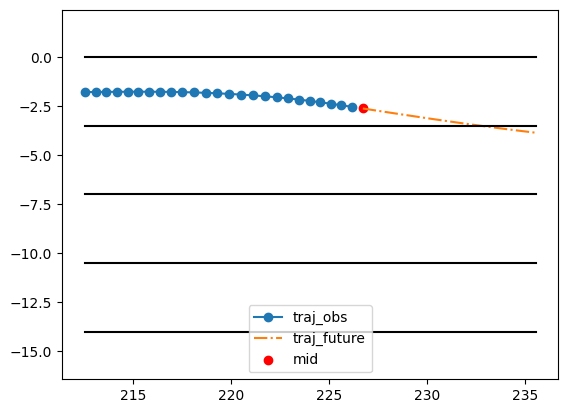

In [15]:
for i in range(3, 50):
    traj = r_data[i]
    plt.plot(traj[:25, 0], traj[:25, 1], '-o',label='traj_obs')
    plt.plot(traj[25:, 0], traj[25:, 1], '-.', label='traj_future')

    break

start = traj[0][0]
end = traj[-1][0]

lane_0 = [[start, 0], [end, 0]]
lane_1 = [[start, -3.5], [end, -3.5]]
lane_2 = [[start, -7], [end, -7]]
lane_3 = [[start, -10.5], [end, -10.5]]
lane_4 = [[start, -14], [end, -14]]
for lane in [lane_0, lane_1, lane_2, lane_3, lane_4]:
    plt.plot([lane[0][0], lane[1][0]], [lane[0][1], lane[1][1]], color='black')

# plt.scatter(traj[0, 0], traj[0, 1], color='g', label='start')
plt.scatter(traj[25, 0], traj[25, 1], color='r', label='mid')
# plt.scatter(traj[-1, 0], traj[-1, 1], color='b', label='end')

plt.axis('equal')
plt.legend()